In [1]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm

In [2]:
### DATA
from data_loader import df_consumption, joiner_official, merge6

opened s1
opened consumption
opened gdp
opened joiner
opened paris


In [3]:
df_master= merge6
df_master.columns

Index(['country_a', 'country_b', 'year', 'a_name', 'b_name', 'imports',
       'exports', 'iso_code_a', 'iso_code_b', 'co2', 'consumption_co2',
       'population', 'gdp', 'co2_b', 'consumption_co2_b', 'population_b',
       'gdp_b', 'imports_a', 'exports_a', 'imports_b', 'exports_b'],
      dtype='object')

In [4]:
paris= pd.read_csv('data/paris.csv')
paris= paris.rename(columns={'base year': 'year'})
paris.dropna(inplace=True)
paris['year']= paris['year'].astype(int)                  
df_paris = pd.merge(paris,df_consumption[['iso_code','year','consumption_co2']],'left',left_on=(['iso_code','year']),right_on=(['iso_code','year']))
df_paris= df_paris.rename(columns={'iso_code': 'iso_code_a'})
df_paris['reduction high']= df_paris['reduction high'].str.rstrip('%').astype('float') / 100.0
# Compute emissions goal for the selected countries
df_paris['Emissions_goal']= df_paris['consumption_co2']*(1-df_paris['reduction high'])

df_paris

,Unnamed: 0,country,iso_code_a,year,target year,reduction low,reduction high,priority_group,consumption_co2,Emissions_goal
0,0,China,CHN,2005,2030.0,20%,0.20,1,4822.978,3858.38240
1,1,USA,USA,2005,2025.0,26%,0.28,1,6547.818,4714.42896
2,2,Austria,AUT,1990,2030.0,40%,0.40,2,82.531,49.51860
3,3,Belgium,BEL,1990,2030.0,40%,0.40,2,147.260,88.35600
4,4,Bulgaria,BGR,1990,2030.0,40%,0.40,2,56.052,33.63120
5,5,Croatia,HRV,1990,2030.0,40%,0.40,2,20.543,12.32580
6,6,Republic of Cyprus,CYP,1990,2030.0,40%,0.40,2,5.784,3.47040
7,7,Czech Republic,CZE,1990,2030.0,40%,0.40,2,163.037,97.82220
8,8,Denmark,DNK,1990,2030.0,40%,0.40,2,57.452,34.47120
9,9,Estonia,EST,1990,2030.0,40%,0.40,2,31.784,19.07040


In [5]:
# Join df_master and paris data
df_master = df_master[(df_master.gdp.notnull())]
df_master['gdp']= df_master['gdp']/1000000 # GDP in millon dollars
df = pd.merge(df_master,df_paris[['iso_code_a','Emissions_goal','priority_group']],'left',on=['iso_code_a'])
df = df.loc[df.consumption_co2.notnull()]

In [6]:
# COLUMNS NEEDED:
# GDP/Cap
df['gdp_percap'] = df.apply(lambda row: row['gdp']*1000 / row['population'], axis=1)
# consumption-based emissions per capita
df.rename(columns = {'consumption_co2':'consumption'}, inplace=True)
df['consumption_percap'] = df['consumption']*1000000 / df['population']
df['consumption_goal'] = df['Emissions_goal']*1000000 / df['population']

# trade per capita
df['exports_percap']=df['exports']/df['population']
df['imports_percap']=df['imports']/df['population']

df['exportstot_percap']=df['exports_a']*1000/df['population']
df['importstot_percap']=df['imports_a']*1000/df['population']

# import_share
df['imports_share'] = df.apply(lambda row: row['imports'] / row['imports_a'], axis=1)

# Marginal propensity of external consumption or total Imports: M/GDP
df['Mg_ImportsTot'] = df['imports_a']/df['gdp']

# Marginal propensity of imports for each trade partner
df['MgM_bilateral'] = df['imports']*100/df['gdp']


In [7]:
# Growth variables
growth= df[['country_a', 'iso_code_a','year','gdp','gdp_percap','imports_a','importstot_percap','Mg_ImportsTot','consumption_percap','population']]
growth= growth.drop_duplicates(subset=['iso_code_a', 'year'], keep='last') #get aggregates by country-year
growth


,country_a,iso_code_a,year,gdp,gdp_percap,imports_a,importstot_percap,Mg_ImportsTot,consumption_percap,population
1954,2,USA,1997,11400000.0,41.955883,885651.80,3.259500,0.077689,20.966068,271713984.0
1955,2,USA,1998,11900000.0,43.245206,933155.60,3.391135,0.078416,21.256654,275175008.0
1956,2,USA,1999,12500000.0,44.875569,1032958.60,3.708368,0.082637,21.660791,278548000.0
1957,2,USA,2000,13000000.0,46.146582,1216111.50,4.316876,0.093547,22.198983,281711008.0
1958,2,USA,2001,13100000.0,46.028221,1158994.90,4.072250,0.088473,21.662413,284608000.0
...,...,...,...,...,...,...,...,...,...,...
105920,900,AUS,2009,927000.0,42.618730,5765.09,0.265049,0.006219,17.253414,21751000.0
105921,900,AUS,2010,994000.0,44.865719,7298.35,0.329422,0.007342,17.305710,22155000.0
105922,900,AUS,2011,1030000.0,45.700595,8619.08,0.382424,0.008368,17.320570,22538000.0
105923,900,AUS,2012,1020000.0,44.533706,8282.99,0.361639,0.008121,17.482710,22904000.0


In [8]:
#compute variation rates of GDP, MgC_imports, and consumption_percap for each year
growth = growth[growth['year']>= 2000]
# compute lagged variables
growth['gdp_lag'] = growth.groupby(['iso_code_a'])['gdp_percap'].shift(1)
growth['MgM_lag'] = growth.groupby(['iso_code_a'])['Mg_ImportsTot'].shift(1)
growth['consump_lag'] = growth.groupby(['iso_code_a'])['consumption_percap'].shift(1)
growth = growth.loc[growth['gdp_lag'].notnull()]

# compute variation rates 
growth['gdp_var']= (growth['gdp_percap']- growth['gdp_lag'])/growth['gdp_lag']
growth['MgM_var']= (growth['Mg_ImportsTot']- growth['MgM_lag'])/growth['MgM_lag']
growth['consump_var']= (growth['consumption_percap']- growth['consump_lag'])/growth['consump_lag']


# Dataframe with growth rates  per country
#Take average growth rates per country
df_growth = growth[['iso_code_a','gdp_var','MgM_var','consump_var']].groupby(['iso_code_a']).agg({'gdp_var':'mean','MgM_var':'mean','consump_var':'mean'}).reset_index()

df_growth

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,iso_code_a,gdp_var,MgM_var,consump_var
0,ALB,0.056006,0.074058,0.044282
1,ARE,-0.025003,0.163558,-0.010991
2,ARG,0.025024,0.102923,0.026249
3,ARM,0.085100,0.103865,0.048360
4,AUS,0.015308,0.054881,0.010290
...,...,...,...,...
111,VEN,0.075480,0.076904,0.118306
112,VNM,0.068400,0.048749,0.100951
113,ZAF,0.025530,0.104843,0.012465
114,ZMB,0.090018,0.050405,0.028435


In [9]:
# Use growth dataframe to compute parameters for the model Consumption ~ B0+ B1*C_t-1 + B2*GDP + B3*Imports
# get list of countries
list_countries= growth['iso_code_a'].unique()

# Iterate over each country
dict_results={}
for country in list_countries.tolist():
    df_country= growth[growth['iso_code_a']== country]
    X= df_country[['consump_lag','gdp_percap','importstot_percap']]
    Y= df_country['consumption_percap']
    result = sm.ols(formula="Y ~ X", data=df_country, missing='drop').fit()
    dict_results.setdefault('iso_code_a',[]).append(country)
    dict_results.setdefault('beta0',[]).append(result.params[0]) # Intercept
    dict_results.setdefault('beta1',[]).append(result.params[1]) # Consumption Lag to account for autocorrelation
    dict_results.setdefault('beta2',[]).append(result.params[2]) # Mg propensity GDP
    dict_results.setdefault('beta3',[]).append(result.params[3]) # Mg propensity Imports
    

In [10]:
result.summary()

/Users/elizabethespinosa/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     23.24
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           0.000142
Time:                        10:10:03   Log-Likelihood:                -3.5043
No. Observations:                  13   AIC:                             15.01
Df Residuals:                       9   BIC:                             17.27
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2317      4.863     -0.459      0.657     -13.233       8.770
X[0]           0.3298      0.377      0.874      0.405      -0.524       1.183
X[1]           0.3701      0.200      1.855      0.097      -0.081       0.821
X[2]          -7.7022      5.809     -1.326      0.218     -20.843       5.439
==============================================================================
Omnibus:                        0.370   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.831   Jarque-Bera (JB):                0.489
Skew:                          -0.232   Prob(JB):                        0.783
Kurtosis:                       2.171   Cond. No.                     3.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# Convert dictionary with parameters to dataframe
df_params= pd.DataFrame.from_dict(dict_results)

## Merge computed parameters in the main dataframe
df= pd.merge(df, df_growth, on=['iso_code_a'], how='inner') #add annual variation rates
df= pd.merge(df, df_params, on=['iso_code_a'], how='inner') #add annual variation rates

In [12]:

df['GDP-X']= (df['gdp_percap']-df['exportstot_percap'])


In [13]:
# Filter year 2000 
df2000= df[df['year']==2000]

## Dynamic Model

In [14]:
# Dataframe at the country level to define node attributes
nodes= df2000.drop_duplicates(subset=['country_a'], keep='first')
nodes= nodes.round(3)
df2000= df2000.round(3)

In [15]:
# Paris agreement priority groups
nodes['priority_group']= nodes['priority_group'].replace(np.nan, 0)

In [16]:
# Classify countries in four groups by GDP
nodes= nodes.sort_values(by=['gdp_percap'], ascending=False).reset_index(drop=True)
nodes['index1']=nodes.index
def classif(r):
    if r< 20:
        m= '1'
    elif r>=20 and r<60:
        m= '2'
    elif r>=60 and r<100:
        m= '3'
    elif r>= 100:
        m= '4'
    return m
nodes['group'] = nodes.index1.apply(classif)

In [17]:
nodes.sort_values(by=['gdp_percap'], ascending=False).reset_index(drop=True)

,country_a,country_b,year,a_name,b_name,imports,exports,iso_code_a,iso_code_b,co2,...,gdp_var,MgM_var,consump_var,beta0,beta1,beta2,beta3,GDP-X,index1,group
0,696,698,2000,United Arab Emirates,Oman,3.100,1484.760,ARE,OMN,111.788,...,-0.025,0.164,-0.011,-3.267,0.089,0.335,0.372,93.636,0,1
1,212,220,2000,Luxembourg,France,1395.220,2603.960,LUX,FRA,8.729,...,-0.008,0.074,0.171,7.829,0.250,-0.040,0.720,49.682,1,1
2,694,696,2000,Qatar,United Arab Emirates,225.240,95.300,QAT,ARE,34.566,...,0.064,0.052,0.007,33.354,0.132,-0.085,0.555,43.909,2,1
3,385,390,2000,Norway,Denmark,2195.910,3163.130,NOR,DNK,42.515,...,0.033,0.067,0.029,0.467,0.634,0.059,-0.279,52.931,3,1
4,2,20,2000,United States of America,Canada,229191.000,169068.000,USA,CAN,5997.299,...,0.008,0.038,-0.013,-3.007,0.853,0.162,-0.368,43.164,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,580,590,2000,Madagascar,Mauritius,10.870,33.590,MDG,MUS,1.867,...,0.024,0.125,0.051,0.093,-0.378,0.085,0.558,0.964,111,4
112,553,560,2000,Malawi,South Africa,260.250,44.650,MWI,ZAF,0.865,...,0.023,0.079,0.015,0.234,-0.106,-0.060,0.564,0.879,112,4
113,517,530,2000,Rwanda,Ethiopia,-9.000,0.023,RWA,ETH,0.520,...,0.063,0.505,0.009,-0.024,1.132,0.016,-0.117,0.722,113,4
114,530,551,2000,Ethiopia,Zambia,0.091,0.076,ETH,ZMB,3.464,...,0.068,0.133,0.071,0.018,0.377,0.048,0.222,0.639,114,4


In [18]:
nodes['priority_group'].value_counts()

0.0    81
2.0    28
1.0     7
Name: priority_group, dtype: int64

In [19]:
## Paris agreement
nodes.groupby(['priority_group'])[['consumption_percap','consumption_goal']].agg('sum')

,consumption_percap,consumption_goal
priority_group,,
0.0,337.656,0.000
1.0,72.615,56.097
2.0,272.563,187.456


In [34]:
nodes[['iso_code_a','country_a','gdp_percap','gdp_var','consumption_percap']][nodes['iso_code_a']=='CHN']

,iso_code_a,country_a,gdp_percap,gdp_var,consumption_percap
79,CHN,710,3.967,0.08,2.295


In [18]:
def initialize():
    global G, nextg, pos
    # Create graph with edge attributes: Imports, parteners_consumption, and Imports growth rate= alpha
    G = nx.from_pandas_edgelist(df2000[['country_a','country_b','imports_percap','exports_percap','MgM_bilateral','MgM_var']], 'country_a', 'country_b', 
                                edge_attr=['imports_percap','exports_percap','MgM_bilateral','MgM_var'], create_using= nx.MultiDiGraph())
        # set graph layout
    pos = nx.spring_layout(G)
        # convert dataframe to dictionary of attributes
    node_attr = nodes[['country_a','exportstot_percap','importstot_percap','GDP-X','gdp_var','consumption_percap','beta0','beta1','beta2','beta3','priority_group']].set_index('country_a').to_dict('index')
    nx.set_node_attributes(G, node_attr)
    
    # remove imbalanced node
    G.remove_node(920)
    
    # Scenario where low priority decreases propensity to import in half
    #for i, j, k, weight in G.edges(data="weight", keys=True): 
        #if G.nodes[i]['priority_group']== 0:
            #G[i][j][0]['MgM_var']= -0.5
            
    
    nextg= G.copy()

In [236]:
initialize()
for i, data in G.nodes.data():
    print(G.nodes(data=True))

[(2, {'exportstot_percap': 2.983, 'importstot_percap': 4.317, 'GDP-X': 0.043, 'gdp_var': 0.008, 'consumption_percap': 22.199, 'beta0': -3.007, 'beta1': 0.853, 'beta2': 0.162, 'beta3': -0.368, 'priority_group': 1.0}), (20, {'exportstot_percap': 1.7, 'importstot_percap': 2.822, 'GDP-X': 0.036, 'gdp_var': 0.009, 'consumption_percap': 18.984, 'beta0': 19.162, 'beta1': -0.592, 'beta2': 0.333, 'beta3': -0.94, 'priority_group': 1.0}), (42, {'exportstot_percap': 0.035, 'importstot_percap': 0.465, 'GDP-X': 0.007, 'gdp_var': 0.04, 'consumption_percap': 3.046, 'beta0': 0.823, 'beta1': 0.769, 'beta2': -0.098, 'beta3': 0.926, 'priority_group': 0.0}), (51, {'exportstot_percap': 0.277, 'importstot_percap': 0.51, 'GDP-X': 0.005, 'gdp_var': 0.025, 'consumption_percap': 2.992, 'beta0': 4.878, 'beta1': 0.379, 'beta2': -0.549, 'beta3': 0.814, 'priority_group': 0.0}), (52, {'exportstot_percap': 0.54, 'importstot_percap': 0.929, 'GDP-X': 0.012, 'gdp_var': 0.075, 'consumption_percap': 12.388, 'beta0': 5.821,

In [161]:
#for i, j, data in G.edges.data():
    #print(G.edges(data=True))
    #break

In [56]:
def update():
    global G, nextg

    # Update GDP with GDP growth rate
    for i in G.nodes():
        try:
            nextg.nodes[i]['GDP_percap'] = (1+ G.nodes[i]['gdp_var'])* (G.nodes[i]['GDP-X'] + G.nodes[i]['exportstot_percap'])
        except:
            continue
        
    # Update GDP_percap without exports (logistic growth)
    
    for i in G.nodes():
        try:
            #if G.nodes[i]['priority_group']== 0:
            nextg.nodes[i]['GDP-X'] = (1+ (G.nodes[i]['gdp_var']*(1-(G.nodes[i]['GDP-X']/65))))* G.nodes[i]['GDP-X']
        except:
            continue
            
    
    # Update Propensity of Imports (bilateral imports)
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        
        nextg[i][j][0]['MgM_bilateral']= (1 + G.edges[i,j,0]['MgM_var'])* (G.edges[i,j,0]['MgM_bilateral'])


    
    # Update Imports variation at edge level
    
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        
        nextg[i][j][0]['imports_percap']= (nextg.edges[i,j,0]['MgM_bilateral']/100)* nextg.nodes[i]['GDP_percap']
    
        
    # Get total imports
    
    for i in nextg.nodes(): 
        nextg.nodes[i]['importstot_percap'] = nextg.out_degree(i,'imports_percap')
    
    # Update bilateral exports based on updated bilateral imports:
    
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        g= nextg[i][j][0]['imports_percap']
        for j, y, z, w in nextg.edges(data="weight", keys=True):
            if y == i:
                nextg[j][y][0]['exports_percap'] = g
            else:
                continue
     
    # Compute total exports
    for i in nextg.nodes(): 
        nextg.nodes[i]['exportstot_percap'] = nextg.out_degree(i,'exports_percap')
 
    
    # Compute consumption-based emissions at node level
    for i in nextg.nodes():
        try:
            nextg.nodes[i]['consumption_percap']= nextg.nodes[i]['beta0'] + nextg.nodes[i]['beta1']*G.nodes[i]['consumption_percap'] + nextg.nodes[i]['beta2']*nextg.nodes[i]['GDP_percap'] + nextg.nodes[i]['beta3']*nextg.nodes[i]['importstot_percap']   
        except:
            nextg.nodes[i]['consumption_percap']=0
            
        if nextg.nodes[i]['consumption_percap']<0:
            nextg.nodes[i]['consumption_percap']=0
    
            
    # Scenario where high priority applies clean technology beta2 is negative= average beta2 in the group
    #for i in nextg.nodes(): 
        #if nextg.nodes[i]['priority_group'] != 0:
            #nextg.nodes[i]['beta2']= -100
            
    # Scenario Reduce propensity rate variation
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        #if nextg.nodes[i]['priority_group']!= 0:
        nextg[i][j][0]['MgM_var']= -0.2
            
    
    # Scenario Degrowth for all countries "Reduce growth convergence!! or any growth"
    for i, j, k, weight in nextg.edges(data="weight", keys=True): 
        if nextg.nodes[i]['gdp_var']> 0.01 : 
            nextg.nodes[i]['gdp_var']= 0.01
        elif nextg.nodes[i]['priority_group']== 0 and nextg.nodes[i]['gdp_var']<= 0.01 :
            nextg.nodes[i]['gdp_var']= -0.01
        
    G= nextg.copy()


In [123]:
def emissions_trend():
    global nextg
    high_income=0
    uppermiddle_income= 0
    lowermiddle_income= 0
    low_income= 0
    for i in nextg.nodes():
        if nextg.nodes[i]['group']=='1':
            high_income+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['group']=='2':
            uppermiddle_income+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['group']=='3':
            lowermiddle_income+= nextg.nodes[i]['consumption_percap']
        else:
            low_income+= nextg.nodes[i]['consumption_percap']
    return high_income, uppermiddle_income, lowermiddle_income, low_income

In [20]:
def priority_groups_trend():
    global nextg
    high_priority=0
    low_priority= 0

    for i in nextg.nodes():
        if nextg.nodes[i]['priority_group']==1.0 or nextg.nodes[i]['priority_group']== 2.0:
            high_priority+= nextg.nodes[i]['consumption_percap']
        elif nextg.nodes[i]['priority_group']==0:
            low_priority+= nextg.nodes[i]['consumption_percap']

    return high_priority, low_priority

### Simulations by group priority

In [57]:
N= 50
initialize()
emissions_highprio=[]
emissions_lowprio=[]

for i in range(N):
    update()
    X,Y = priority_groups_trend() # Get consumption by groups at the end of period
    emissions_highprio.append(X) # array of total consumption for high priority countries
    emissions_lowprio.append(Y) # array of total consumption for low countries
        
    

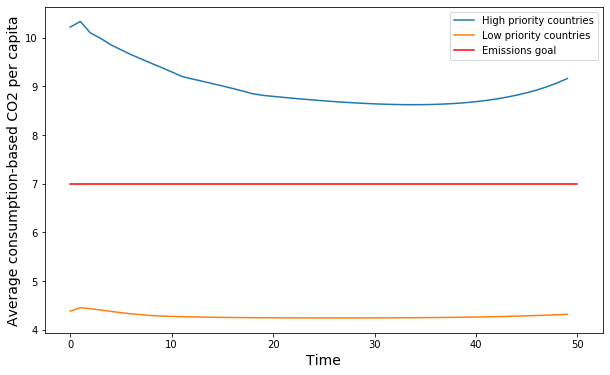

In [59]:
plt.figure(figsize=(10,6))
plt.plot(range(N),[x / 35 for x in emissions_highprio][0:N], label='High priority countries')
plt.plot(range(N),[x / 81 for x in emissions_lowprio][0:N], label='Low priority countries')
plt.plot([0, N], [7, 7], 'r-', label='Emissions goal')


plt.xlabel('Time', fontsize=14)
plt.ylabel('Average consumption-based CO2 per capita', fontsize=14)
plt.legend(fontsize=10)

In [113]:
nodes[(nodes['priority_group']==1.0) | (nodes['priority_group']== 2.0) ].describe()

,country_a,country_b,year,imports,exports,co2,consumption,population,gdp,co2_b,...,MgM_bilateral,gdp_var,MgM_var,consump_var,beta0,beta1,beta2,beta3,GDP-X,index1
count,35.000000,35.000000,35.0,35.0000,35.000000,35.000000,35.000000,3.500000e+01,3.500000e+01,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,341.771429,350.457143,2000.0,8820.2482,7683.328914,513.562714,521.990514,1.015427e+08,1.160501e+06,193.021514,...,0.795686,0.028314,0.076457,0.007000,8.302371,0.346229,-78.466029,112.885686,0.022086,31.571429
std,184.956129,185.648679,0.0,38540.9363,28633.669247,1148.479303,1158.030873,2.758951e+08,2.383358e+06,332.221153,...,1.092008,0.025337,0.031943,0.036514,12.579053,0.422477,408.368317,1883.354387,0.011846,21.778681
min,2.000000,20.000000,2000.0,-9.0000,0.672000,2.526000,4.106000,3.940000e+05,9.422896e+03,2.526000,...,-0.096000,-0.008000,0.003000,-0.029000,-11.285000,-0.592000,-1268.554000,-7702.190000,0.002000,1.000000
25%,232.500000,245.000000,2000.0,108.8450,130.580000,43.212000,42.618000,4.808000e+06,7.126644e+04,13.574000,...,0.037500,0.011500,0.057000,-0.012500,1.403000,0.074500,-255.002000,17.741500,0.012000,15.000000
50%,338.000000,339.000000,2000.0,867.8900,663.080000,95.427000,91.749000,1.028900e+07,2.480000e+05,54.678000,...,0.393000,0.016000,0.074000,-0.000000,5.961000,0.335000,-75.867000,361.461000,0.022000,28.000000
75%,366.500000,367.500000,2000.0,3093.5250,3719.650000,383.132500,434.033000,4.875850e+07,1.205000e+06,149.501500,...,1.104000,0.047000,0.092500,0.011500,10.448000,0.596000,94.342000,779.140500,0.031500,44.000000
max,900.000000,920.000000,2000.0,229191.0000,169068.000000,5997.299000,6253.698000,1.290551e+09,1.300000e+07,1471.235000,...,5.007000,0.084000,0.150000,0.171000,63.140000,1.146000,1115.526000,2116.542000,0.050000,95.000000


In [114]:
nodes[(nodes['priority_group']==0.0) ].describe()

,country_a,country_b,year,imports,exports,co2,consumption,population,gdp,co2_b,...,MgM_bilateral,gdp_var,MgM_var,consump_var,beta0,beta1,beta2,beta3,GDP-X,index1
count,81.000000,81.000000,81.0,81.000000,81.000000,81.000000,81.000000,8.100000e+01,8.100000e+01,81.000000,...,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,480.679012,489.024691,2000.0,1021.974309,1030.083753,69.452741,66.488654,2.597917e+07,1.811802e+05,130.908296,...,0.358420,0.047605,0.121568,0.048679,2.653481,0.263136,34.646593,853.995037,0.009926,68.703704
std,253.270746,254.464043,0.0,4149.440851,3853.118157,117.373192,118.098430,3.694631e+07,3.138760e+05,404.219854,...,0.720045,0.029829,0.132555,0.062570,5.697705,0.355252,199.261000,3182.399998,0.014395,31.670351
min,42.000000,51.000000,2000.0,-9.000000,0.000000,0.520000,0.520000,3.330000e+05,5.673135e+03,0.520000,...,-0.159000,-0.026000,-0.023000,-0.018000,-3.267000,-0.554000,-687.264000,-11603.769000,0.001000,0.000000
25%,225.000000,230.000000,2000.0,3.290000,2.940000,3.606000,4.874000,4.921000e+06,1.639901e+04,3.606000,...,0.007000,0.026000,0.054000,0.012000,0.104000,0.054000,-59.789000,-226.312000,0.002000,47.000000
50%,530.000000,551.000000,2000.0,36.380000,39.940000,15.200000,14.825000,1.114900e+07,4.106372e+04,20.563000,...,0.079000,0.044000,0.079000,0.036000,0.703000,0.244000,49.132000,427.184000,0.005000,73.000000
75%,694.000000,698.000000,2000.0,225.240000,239.720000,59.519000,65.970000,2.879400e+07,2.180000e+05,78.823000,...,0.343000,0.066000,0.133000,0.059000,2.456000,0.509000,134.704000,814.108000,0.011000,94.000000
max,850.000000,900.000000,2000.0,31827.900000,22847.600000,567.186000,680.513000,2.115140e+08,2.030000e+06,3349.295000,...,4.231000,0.158000,0.825000,0.388000,33.354000,1.420000,530.590000,15840.194000,0.094000,115.000000


def grouping_grapher(df):
    df = network_df
    y = 'consumption_percap'
    grouped = df[['time',y,'region']].groupby(['time','region']).agg({y:'sum'}).reset_index()
    # sns.lineplot(x="year", y="consumption_percap",hue="iso_code_a", data=growth[growth['region']=='Europe'])
    sns.lineplot(x='time', y=y,hue='region', data=grouped)